
#**Priors**

Es una distribución que busca entregar data del caso analizado, sin haber realizado un estudio de muestras previas obtenidas, únicamente a partir de la información que se obtiene del contexto. El objetivo de este es descartar valores no razonables para el parámetro.

Existen distintas categorías de priors dependiendo de sus características.

La primera de ellas hace relación a qué tan "informativos" son, donde el principal punto a tener en cuenta en caso de utilizar un prior débilmente informativo es asegurar una data extensa para el likelihood, pues esta corregirá el efecto del priors débilmente informativo en el posterior. 
Esto es de vital importancia pues pese a que existe la posibilidad de definir un prior fuertemente informativo, bajo la utilización de este se corren riesgos de omitir valores que siguen siendo posibles.

El parámetro por debilmente informativo por defecto que se utiliza al modelar es una distribución uniforme (0,1). Sin embargo, esta no es recomendable, a excepción de algunos casos.

Los priors también pieden clasifircarse como apropiados o no. Para saber esto basta con integrar la función de densidad, y en caso de obtener como resultado infinito, estaríamos hablando de un prior no apropiado. El impacto en la utilización de este tipo de priors se da si no se dispone de un posterior apropiado. Esto no es necesario en el caso de los priors apropiados, pues estos aseguran que el posterior también lo sea. 

## **Modelando priors para los casos positivos de COVID en Chile**

### **Cargando librerías**

In [1]:
import pystan as py
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


### **Leyendo datos**

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto49/Positividad_Diaria_Media_T.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'], format = '%Y-%m-%d')
df = df[df['Fecha']>'2022-01']
df['pcr'] = df['pcr'].astype(int)
df['casos pcr'] = df['casos pcr'].astype(int)
df['casos ag'] = df['casos ag'].astype(int)

In [3]:
df

,Fecha,pcr,casos pcr,casos ag,positividad pcr,mediamovil_positividad_pcr
648,2022-01-02,54709,1723,198,0.0315,0.0270
649,2022-01-03,23586,870,135,0.0369,0.0286
650,2022-01-04,21305,810,248,0.0380,0.0300
651,2022-01-05,43127,1380,478,0.0320,0.0314
652,2022-01-06,64928,2493,641,0.0384,0.0334
...,...,...,...,...,...,...
789,2022-05-23,32084,2416,1211,0.0753,0.0858
790,2022-05-24,19120,1865,1314,0.0975,0.0888
791,2022-05-25,30941,3152,2858,0.1019,0.0907
792,2022-05-26,47532,4972,2578,0.1046,0.0931


In [4]:
# Añadiendo columna que ""cuenta"" los días
dias = list(range(1,147))
df['días'] = dias

In [5]:
# Añadiendo columna que agregue casos de exámen pcr y antígeno
df ['casos']= df['casos pcr'] +df['casos ag']

In [6]:
# Cambiando nommbres de columnas por comodidad
df. rename(columns = {'Fecha': 'fecha','casos pcr':'casos_pcr', 'casos ag':'casos_ag','positividad pcr':'pos_pcr', 'mediamovil_positividad_pcr':'mm_pos_pcr'}, inplace = True)

In [7]:
df.head()

,fecha,pcr,casos_pcr,casos_ag,pos_pcr,mm_pos_pcr,días,casos
648,2022-01-02,54709,1723,198,0.0315,0.0270,1,1921
649,2022-01-03,23586,870,135,0.0369,0.0286,2,1005
650,2022-01-04,21305,810,248,0.0380,0.0300,3,1058
651,2022-01-05,43127,1380,478,0.0320,0.0314,4,1858
652,2022-01-06,64928,2493,641,0.0384,0.0334,5,3134


In [8]:
# Dimensión
df.shape

(146, 8)

#### *Datos*
* pcr: número total de exámenes PCR realizados durante el último día.
* casos: número de casos nuevos totales (pcr y antígeno).
* positividad: casos/pcr.
* mediamovil_positividad: promedio móvil de la positividad en el lapso de 7 días.

In [9]:
# Chequeo de nulos
df.isnull().any()

fecha         False
pcr           False
casos_pcr     False
casos_ag      False
pos_pcr       False
mm_pos_pcr    False
días          False
casos         False
dtype: bool

In [10]:
# Chequeo de NaN
df.isna().any()

fecha         False
pcr           False
casos_pcr     False
casos_ag      False
pos_pcr       False
mm_pos_pcr    False
días          False
casos         False
dtype: bool

In [11]:
# Verificación de tipos de datos
df.dtypes

fecha         datetime64[ns]
pcr                    int64
casos_pcr              int64
casos_ag               int64
pos_pcr              float64
mm_pos_pcr           float64
días                   int64
casos                  int64
dtype: object

In [12]:
# Revisión estadística
df.describe()

,pcr,casos_pcr,casos_ag,pos_pcr,mm_pos_pcr,días,casos
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,56375.438356,8349.452055,3607.534247,0.122579,0.121042,73.500000,11956.986301
std,24888.544669,7877.491491,3342.434564,0.078681,0.078972,42.290661,11086.242065
min,14575.000000,554.000000,135.000000,0.031500,0.027000,1.000000,993.000000
25%,36116.750000,1979.750000,954.750000,0.054350,0.051375,37.250000,2987.750000
50%,52708.500000,4668.500000,1981.000000,0.089950,0.087950,73.500000,7369.500000
75%,75965.750000,12883.250000,6076.250000,0.190300,0.190225,109.750000,18857.750000
max,109905.000000,27793.000000,11176.000000,0.284200,0.273000,146.000000,38446.000000


### **Plot**

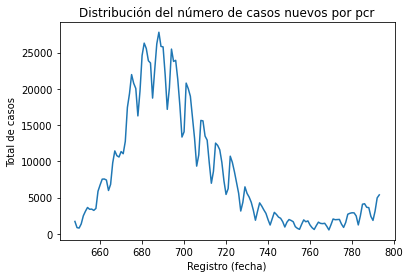

In [13]:
plt.xlabel("Registro (fecha)")
plt.ylabel("Total de casos")
plt.title("Distribución del número de casos nuevos por pcr")
plt.plot(df.casos_pcr)

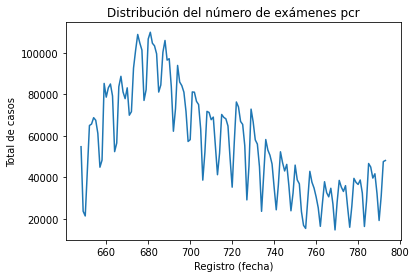

In [14]:
plt.xlabel("Registro (fecha)")
plt.ylabel("Total de casos")
plt.title("Distribución del número de exámenes pcr")
plt.plot(df.pcr)

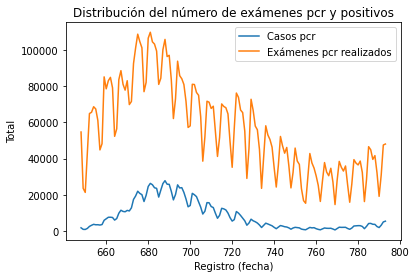

In [15]:
plt.xlabel("Registro (fecha)")
plt.ylabel("Total")
plt.title("Distribución del número de exámenes pcr y positivos")
plt.plot(df.casos_pcr, label = 'Casos pcr')
plt.plot(df.pcr, label = 'Exámenes pcr realizados')
plt.legend()

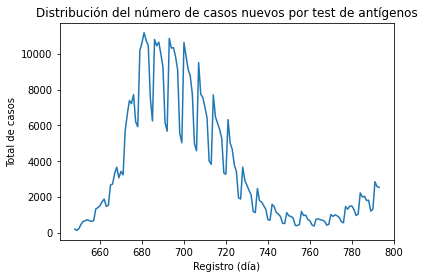

In [16]:
plt.xlabel("Registro (día)")
plt.ylabel("Total de casos")
plt.title("Distribución del número de casos nuevos por test de antígenos")
plt.plot(df.casos_ag)

In [17]:
df1 = df.iloc[0:30]

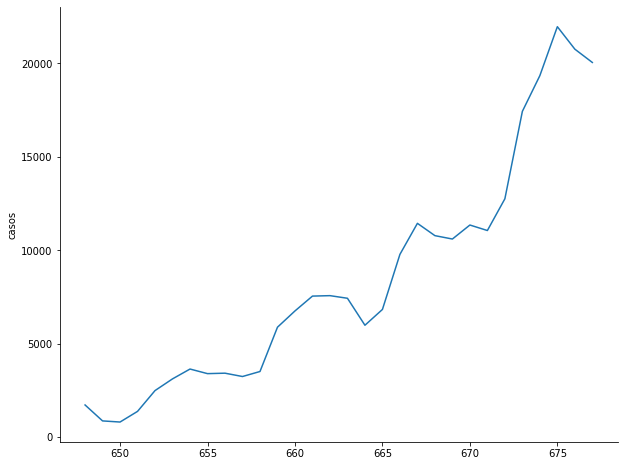

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
df1.casos_pcr.plot(ax=ax)
ax.set(ylabel='casos')
sns.despine()

### **Modelo 1**

In [19]:
import pymc3 as pm
import arviz as az

In [22]:
t = df1.días
confirmed = df1.casos
    
with pm.Model() as model1:
    # Intercept
    a = pm.Normal('a', mu=0, sigma=100) #Prior debilmente informativo
    
    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.3) #Prior fuertemente informativo
    
    # Exponential regression
    growth = a * (1 + b) ** t
    
    # Error term    
    eps = pm.HalfNormal('eps')
    
    # Likelihood
    pm.Normal('obs', 
              mu=growth, 
              sigma=eps,
              observed=confirmed)

In [23]:
with model1:
    prior_pred = pm.sample_prior_predictive()

INFO:/usr/local/lib/python3.7/dist-packages/theano/link/c/lazylinker_c.py:Compiling new CVM
INFO:/usr/local/lib/python3.7/dist-packages/theano/link/c/lazylinker_c.py:New version 0.211


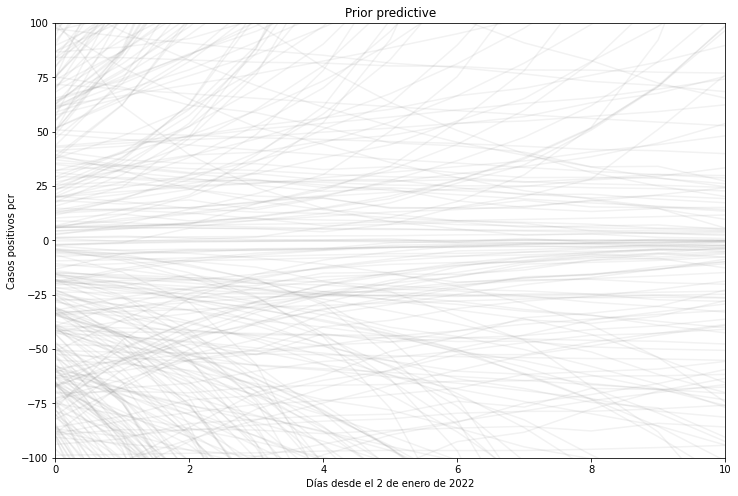

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['obs'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 100),
       xlim=(0, 10),
       title="Prior predictive", 
       xlabel="Días desde el 2 de enero de 2022",
       ylabel="Casos positivos pcr");

### Evaluando el prior: ¿el modelo produce los patrones que espero?

#### El prior utilizado es incorrecto debido a tres condiciones: los casos no pueden ser negativos y no pueden comenzar con el valor 0 (todos los valores son superiores a 500 pacientes).

### **Fiteando el modelo y evaluando convergencia**

In [25]:
sampler_kwarge = {"chains":4,"cores":4,"return_inferencedata":True}

In [26]:
with model1:
    trace1 = pm.sample(**sampler_kwarge)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [eps, b, a]


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpot

RuntimeError: ignored

### Los problemas que se identificaron son: 

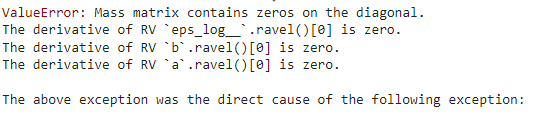

In [27]:
with model1:
    trace1 = pm.sample(tune=0, draws=500, return_inferencedata=True) 

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [eps, b, a]


INFO:pymc3:Sampling 2 chains for 0 tune and 500 draw iterations (0 + 1_000 draws total) took 1 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


#### Obs. tune = 0 evita que el proceso de detenga permitiendo comprender el problema, en este caso todos los valores divergen, como debiera verde en el arviz a continuación, aunque en este caso en particular no se obtuvo ningún resultado.

/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your d

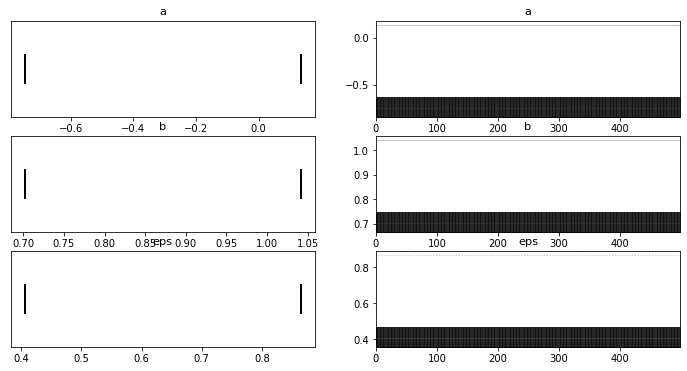

In [28]:
az.plot_trace(trace1);

### **Modelo 2**

In [29]:
with pm.Model() as model2:
    # Intercept
    a = pm.Normal('a', mu=100, sigma=25) #El cambio pretende solucionar la problematica de que los valores comienzan en 0, 
                                         #cuando se espera estos sean cercanos a 100 en el caso ejemplo. En este caso una opción a evaluar seria definir mu=500,
    
    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.1) #El cambio realizado permite centrar más los valores en la métrica previamente conocida, evitando valores negativos,
                                          #los cuales debido a que mu es cercano a cero, es probable que este sea el causante de esta problematica.
    
    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood
    pm.NegativeBinomial('obs', 
              growth, 
              alpha=pm.Gamma("alpha",mu=6, sigma=1),
              observed=confirmed)

### Evaluando el prior: ¿el modelo produce los patrones que espero?

In [30]:
with model2:
    prior_pred = pm.sample_prior_predictive()

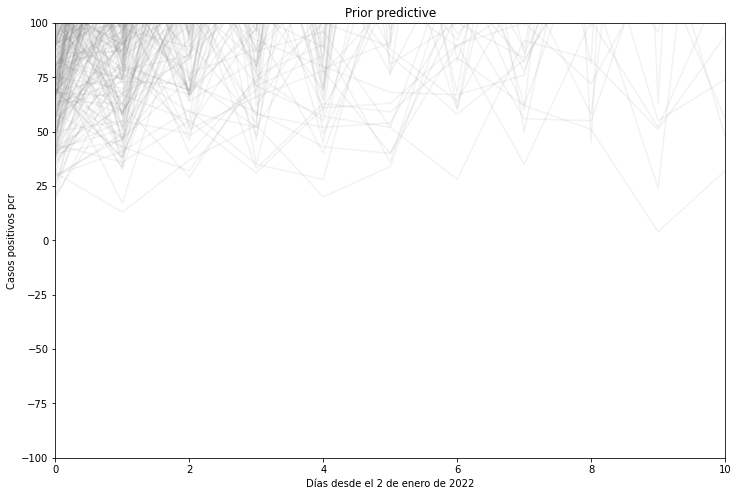

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['obs'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 100),
       xlim=(0, 10),
       title="Prior predictive", 
       xlabel="Días desde el 2 de enero de 2022",
       ylabel="Casos positivos pcr");

El prior utilizado esta vez sí cumple con entregar solo valores positivos y mayor a 0 en su comienzo, por lo que podemos decir al menos que este estimador es más adecuado que el anterior.

### **Fiteando el modelo y evaluando convergencia**


In [32]:
with model2:
    trace2 = pm.sample(**sampler_kwarge)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [alpha, b, a]


INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  


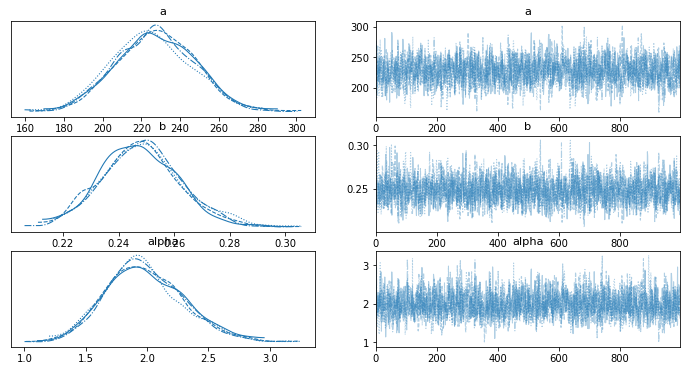

In [33]:
with model2:
    pm.traceplot(trace2);

In [34]:
az.summary(trace2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,226.912,20.604,189.517,265.573,0.520,0.368,1569.0,2177.0,1.0
b,0.248,0.014,0.222,0.276,0.000,0.000,1887.0,2342.0,1.0
alpha,1.984,0.321,1.390,2.579,0.007,0.005,1933.0,2395.0,1.0


#### Obs. Considerando que el r_hat dio en todos los casos 1, se confirma que el prior permitió obtener en cada cadena evaluada distribuciones para los parametros estimados significativamente similares, como se observa en el gráfico a continuación.

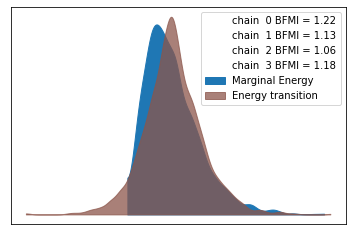

In [35]:
az.plot_energy(trace2);